# Análisis de Sentimientos - Opiniones de Películas IMDB

## Importación de Librerías

In [1]:
import nltk
import re
import string

import numpy as np
import pandas as pd
import seaborn as sns

from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

2024-03-13 18:25:38.755859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/anpinto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anpinto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset

In [3]:
imdb_df = pd.read_csv("data/IMDB_dataset.csv")
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
imdb_df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

<Axes: ylabel='sentiment'>

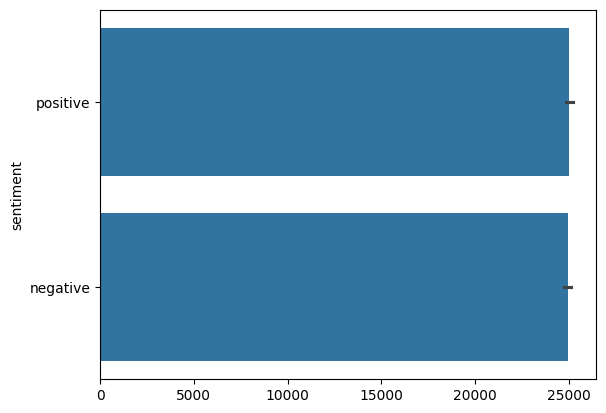

In [6]:
sns.barplot(imdb_df["sentiment"])

## Data Preprocessing

### Data Cleaning

In [7]:
imdb_df.isna().sum()

review       0
sentiment    0
dtype: int64

In [8]:
imdb_df['sentiment'] =  imdb_df['sentiment'].apply(lambda sentiment: 1 if sentiment == 'positive' else 0)
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [9]:
imdb_df["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [10]:
def remove_html_tags(text):
    clean_text = re.sub(r'<.*?>', '', text)
    return clean_text

In [11]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:
def remove_stopwords(text):
    without_sw_list = [word for word in text.split() if word not in (stop_words)]
    return ' '.join(without_sw_list)

In [13]:
def clean_text(text):
    clean_text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    return clean_text.lower()

In [14]:
imdb_df['review'] = imdb_df['review'].apply(lambda review: remove_html_tags(review))
imdb_df["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [15]:
imdb_df['review'] = imdb_df['review'].apply(lambda review: remove_stopwords(review))
imdb_df.iloc[0]['review']

"One reviewers mentioned watching 1 Oz episode hooked. They right, exactly happened me.The first thing struck Oz brutality unflinching scenes violence, set right word GO. Trust me, show faint hearted timid. This show pulls punches regards drugs, sex violence. Its hardcore, classic use word.It called OZ nickname given Oswald Maximum Security State Penitentary. It focuses mainly Emerald City, experimental section prison cells glass fronts face inwards, privacy high agenda. Em City home many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish more....so scuffles, death stares, dodgy dealings shady agreements never far away.I would say main appeal show due fact goes shows dare. Forget pretty pictures painted mainstream audiences, forget charm, forget romance...OZ mess around. The first episode I ever saw struck nasty surreal, I say I ready it, I watched more, I developed taste Oz, got accustomed high levels graphic violence. Not violence, injustice (crooked guards who'll sold 

In [16]:
imdb_df['review'] = imdb_df['review'].apply(lambda review: clean_text(review))
imdb_df.iloc[0]['review']

'one reviewers mentioned watching 1 oz episode hooked they right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust me show faint hearted timid this show pulls punches regards drugs sex violence its hardcore classic use wordit called oz nickname given oswald maximum security state penitentary it focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around the first episode i ever saw struck nasty surreal i say i ready it i watched more i developed taste oz got accustomed high levels graphic violence not violence injustice crooked guards wholl sold nickel inmates wholl kill order get away it w

## Tokenzación del texto

In [17]:
max_features=5000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(imdb_df['review'].values)

In [18]:
list(tokenizer.word_index.items())[:5]

[('i', 1), ('movie', 2), ('the', 3), ('film', 4), ('one', 5)]

In [19]:
X = tokenizer.texts_to_sequences(imdb_df['review'].values)
X

[[5,
  1888,
  1007,
  69,
  439,
  3308,
  324,
  3126,
  127,
  121,
  530,
  519,
  24,
  70,
  3198,
  3308,
  59,
  521,
  206,
  121,
  601,
  63,
  1682,
  150,
  49,
  8,
  49,
  2448,
  1411,
  313,
  521,
  41,
  3361,
  281,
  267,
  394,
  3308,
  274,
  2508,
  1004,
  6,
  2572,
  1315,
  469,
  4666,
  2465,
  1149,
  2926,
  337,
  244,
  3652,
  469,
  270,
  2407,
  256,
  40,
  143,
  11,
  54,
  189,
  1242,
  49,
  603,
  106,
  181,
  174,
  2939,
  760,
  97,
  1214,
  4273,
  2443,
  1044,
  760,
  1352,
  760,
  913,
  101,
  3,
  24,
  324,
  1,
  51,
  118,
  3198,
  1527,
  2151,
  1,
  54,
  1,
  1497,
  6,
  1,
  196,
  461,
  1,
  1408,
  1191,
  3308,
  102,
  244,
  2030,
  2043,
  521,
  91,
  521,
  4893,
  2894,
  423,
  551,
  18,
  158,
  6,
  17,
  689,
  749,
  595,
  1149,
  603,
  486,
  868,
  1939,
  1149,
  491,
  69,
  3308,
  113,
  341,
  3706,
  3216,
  18,
  1152,
  3967,
  435],
 [48,
  315,
  44,
  288,
  3,
  1303,
  2959,
  1576,
  

In [20]:
X = pad_sequences(X,maxlen=600)
X

array([[   0,    0,    0, ..., 1152, 3967,  435],
       [   0,    0,    0, ..., 1848,   17,  142],
       [   0,    0,    0, ...,   63,   14,  259],
       ...,
       [   0,    0,    0, ...,    8,  289, 1597],
       [   0,    0,    0, ..., 4236,  649,  587],
       [   0,    0,    0, ..., 4170,  781,    2]], dtype=int32)

## División del Dataset: Train y Test

In [21]:
y = imdb_df['sentiment']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,
    random_state = 42
)

## Modelo

### Creación del Modelo

In [23]:
embed_dim = 128
lstm_out = 128

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 128)          640000    
                                                                 
 spatial_dropout1d (Spatial  (None, 600, 128)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 771713 (2.94 MB)
Trainable params: 771713 (2.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Compilación del Modelo

In [24]:
model.compile(loss='bce', optimizer='adam',metrics=['accuracy'])

### Entrenamiento del Modelo

In [25]:
epochs = 1
validation_split = 0.1

model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_split=validation_split,
    verbose=True
)

1266/1266 [==============================] - 3241s 3s/step - loss: 0.3658 - accuracy: 0.8413 - val_loss: 0.3044 - val_accuracy: 0.8802


### Evaluación del Modelo

In [35]:
y_pred = np.round(model.predict(X_test))
cf_matrix = confusion_matrix(y_test, predictions)
cf_matrix

157/157 [==============================] - 12s 75ms/step


array([[2061,  420],
       [ 172, 2347]])

<Axes: >

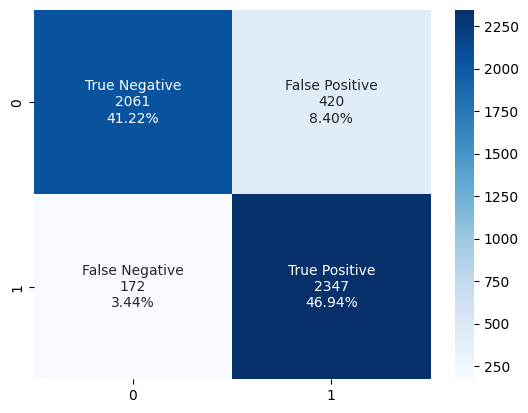

In [57]:
group_lengends = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_lengends, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      2481
           1       0.85      0.93      0.89      2519

    accuracy                           0.88      5000
   macro avg       0.89      0.88      0.88      5000
weighted avg       0.89      0.88      0.88      5000

